In [1]:
from crypto_volatility_lab.data_construction import CryptoScraper, TimeSeriesCreator
import matplotlib.pyplot as plt
import numpy as np

# Web Scraping

### Récupération d'une seule currency

In [2]:
crypto_scraper = CryptoScraper()
bitcoin_data = crypto_scraper.get_data_for_currency('BTC-USD')

In [3]:
print(bitcoin_data.shape)
bitcoin_data.head()

(3768, 7)


,Date,Open,High,Low,Close,Adj,Volume
0,"Jan 9, 2025","95,038.08","95,306.11","92,827.66","93,481.88","93,481.88","63,146,934,272"
1,"Jan 8, 2025","96,924.16","97,258.32","92,525.84","95,043.52","95,043.52","63,875,859,171"
2,"Jan 7, 2025","102,248.85","102,712.48","96,132.88","96,922.70","96,922.70","58,685,738,547"
3,"Jan 6, 2025","98,314.95","102,482.88","97,926.15","102,078.09","102,078.09","51,823,432,705"
4,"Jan 5, 2025","98,233.91","98,813.30","97,291.77","98,314.96","98,314.96","20,525,254,825"


#### Création des time series

In [4]:
ts_creator = TimeSeriesCreator(data=bitcoin_data, date_column_name='Date', value_column_name='Close')
log_returns = ts_creator.create_log_return_time_series()
volatility = ts_creator.create_volatility_time_series()

bitcoin_data["Log Returns"] = log_returns
bitcoin_data["Volatility"] = volatility
bitcoin_data.head(5)

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility
3767,2014-09-17,465.86,468.17,452.42,457.33,457.33,"21,056,800",NaN,NaN
3766,2014-09-18,456.86,456.86,413.10,424.44,424.44,"34,483,200",-0.074635,NaN
3765,2014-09-19,424.10,427.83,384.53,394.80,394.80,"37,919,700",-0.072391,NaN
3764,2014-09-20,394.67,423.30,389.88,408.90,408.90,"36,863,600",0.035091,NaN
3763,2014-09-21,408.08,412.43,393.18,398.82,398.82,"26,580,100",-0.024960,NaN


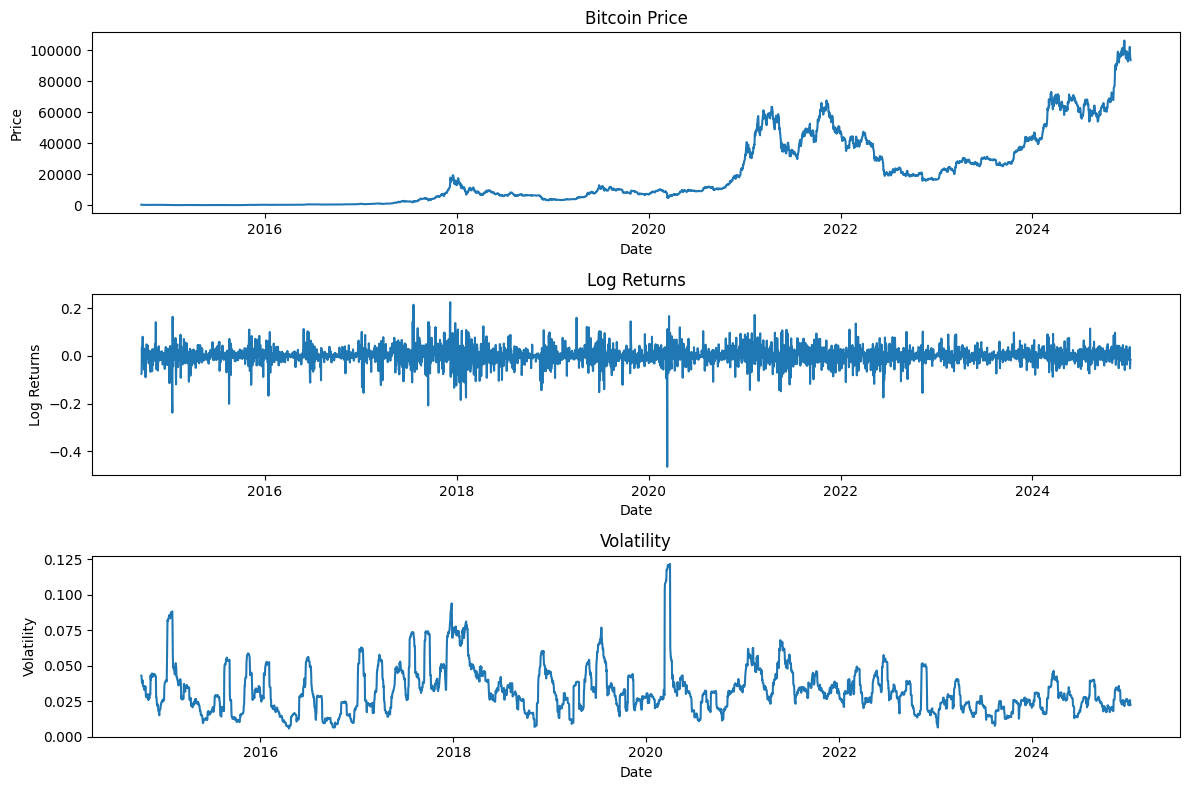

In [5]:
# sort the data by descending date
bitcoin_data = bitcoin_data.sort_values(by="Date", ascending=True)

# plotting time series by date
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

ax[0].plot(bitcoin_data["Date"], bitcoin_data["Close"])
ax[0].set_title("Bitcoin Price")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")

ax[1].plot(bitcoin_data["Date"], bitcoin_data["Log Returns"])
ax[1].set_title("Log Returns")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Log Returns")

ax[2].plot(bitcoin_data["Date"], bitcoin_data["Volatility"])
ax[2].set_title("Volatility")
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Volatility")



plt.tight_layout()
plt.show()

### Création des features

In [6]:
bitcoin_data.dropna(inplace=True)

In [7]:
from crypto_volatility_lab.data_construction import FeaturesCreator
features_creator = FeaturesCreator(data=bitcoin_data, date_column_name='Date', returns_column_name='Log Returns', volatility_column_name='Volatility')
features = features_creator.create_features()

In [8]:
features

,Date,GARCH Volatility,Volatility (Weekly),Volatility (Monthly),Volatility
3746,2014-10-08,0.030919,0.042931,0.042931,0.042931
3745,2014-10-09,0.032966,0.042244,0.042244,0.041557
3744,2014-10-10,0.032929,0.041095,0.041095,0.038797
3743,2014-10-11,0.031521,0.040267,0.040267,0.037781
3742,2014-10-12,0.030014,0.040013,0.040013,0.038999
...,...,...,...,...,...
4,2025-01-05,0.022552,0.023178,0.024264,0.021971
3,2025-01-06,0.021775,0.023019,0.024284,0.023337
2,2025-01-07,0.023905,0.023192,0.024388,0.025742
1,2025-01-08,0.028586,0.023271,0.024329,0.022805


MSE: 4.366314475368422e-05
MAE: 0.004882653923588493
MAPE: 0.1933331051304414


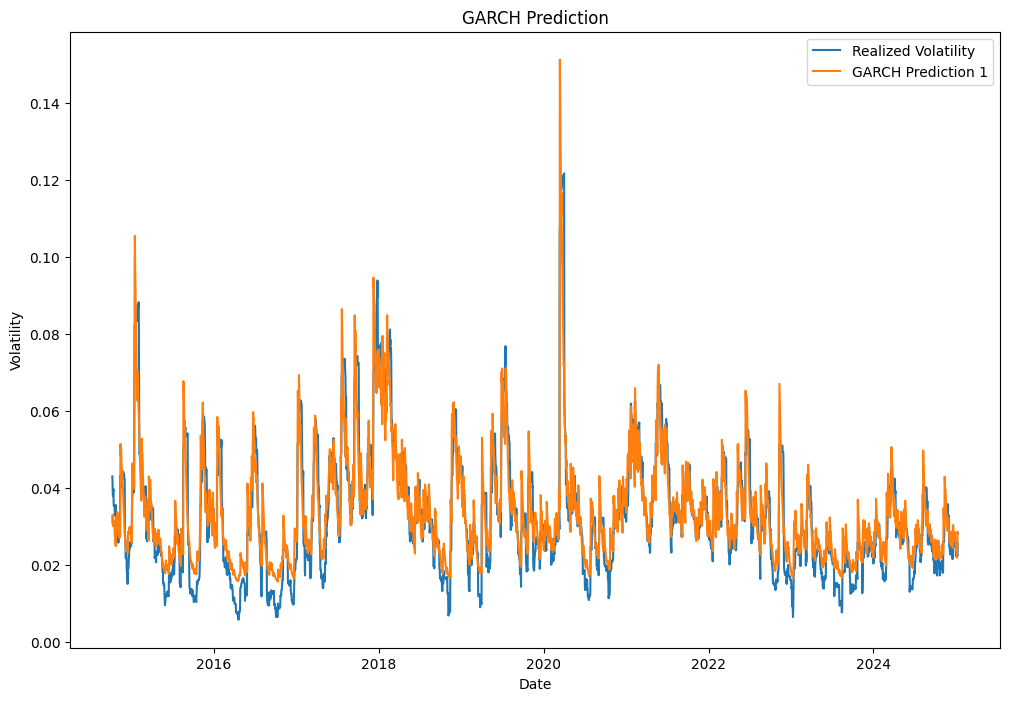

In [9]:
# Compute MSE
mse = np.mean(np.square(features["Volatility"] - features["GARCH Volatility"]))
print(f"MSE: {mse}")

mae = np.mean(np.abs(features["Volatility"] - features["GARCH Volatility"]))
print(f"MAE: {mae}")

mape = np.mean(np.abs((features["Volatility"] - features["GARCH Volatility"]) / features["Volatility"]))
print(f"MAPE: {mape}")

# plot the GARCH forecast
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(features["Date"], features["Volatility"], label="Realized Volatility")
ax.plot(features["Date"], features["GARCH Volatility"], label="GARCH Prediction 1")
ax.set_title("GARCH Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
ax.legend()

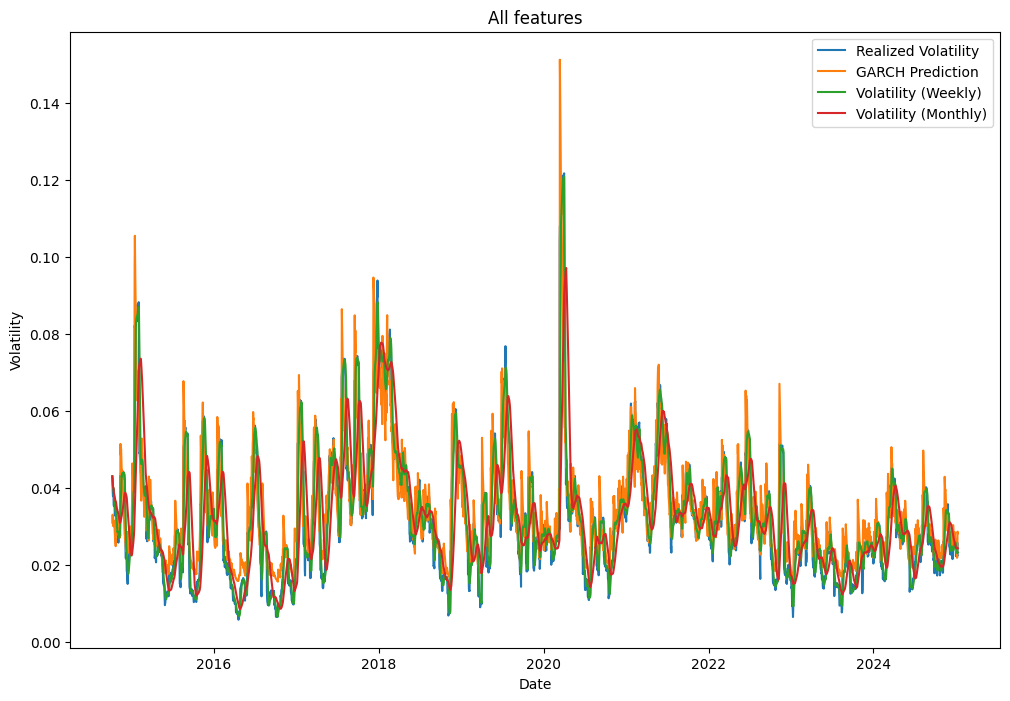

In [10]:
# all features
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(features["Date"], features["Volatility"], label="Realized Volatility")
ax.plot(features["Date"], features["GARCH Volatility"], label="GARCH Prediction")
ax.plot(features["Date"], features["Volatility (Weekly)"], label="Volatility (Weekly)")
ax.plot(features["Date"], features["Volatility (Monthly)"], label="Volatility (Monthly)")
ax.set_title("All features")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
ax.legend()

### Modèle LSTM

In [11]:
features

,Date,GARCH Volatility,Volatility (Weekly),Volatility (Monthly),Volatility
3746,2014-10-08,0.030919,0.042931,0.042931,0.042931
3745,2014-10-09,0.032966,0.042244,0.042244,0.041557
3744,2014-10-10,0.032929,0.041095,0.041095,0.038797
3743,2014-10-11,0.031521,0.040267,0.040267,0.037781
3742,2014-10-12,0.030014,0.040013,0.040013,0.038999
...,...,...,...,...,...
4,2025-01-05,0.022552,0.023178,0.024264,0.021971
3,2025-01-06,0.021775,0.023019,0.024284,0.023337
2,2025-01-07,0.023905,0.023192,0.024388,0.025742
1,2025-01-08,0.028586,0.023271,0.024329,0.022805


In [12]:
from crypto_volatility_lab.modeling import LSTMPipeline

data = features[["Volatility", "GARCH Volatility", "Volatility (Weekly)", "Volatility (Monthly)"]].values
pipeline = LSTMPipeline(forecast_horizon=1, epochs=80, batch_size=32, validation_split=0.1)

model = pipeline.fit(data, features["Volatility"].values.astype(np.float64))

Epoch 1/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.7445e-04 - val_loss: 1.5282e-05
Epoch 2/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.1565e-05 - val_loss: 1.2485e-05
Epoch 3/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5762e-05 - val_loss: 1.4569e-05
Epoch 4/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.9267e-05 - val_loss: 2.1291e-05
Epoch 5/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.9879e-05 - val_loss: 7.1909e-06
Epoch 6/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7430e-05 - val_loss: 7.1604e-06
Epoch 7/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5329e-05 - val_loss: 7.4247e-06
Epoch 8/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5115e-05 - val_loss: 8.6141e-06
Epoch 9/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2446e-05 - val_loss: 1.0251e-05
Epoch 10/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.8424e-05 - val_loss: 9.5449e-06
Epoch 11/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - los

In [13]:
pipeline.evaluate_metrics(data, features["Volatility"].values.astype(np.float64))

Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0021
Mean Absolute Percentage Error (MAPE): 9.0646%


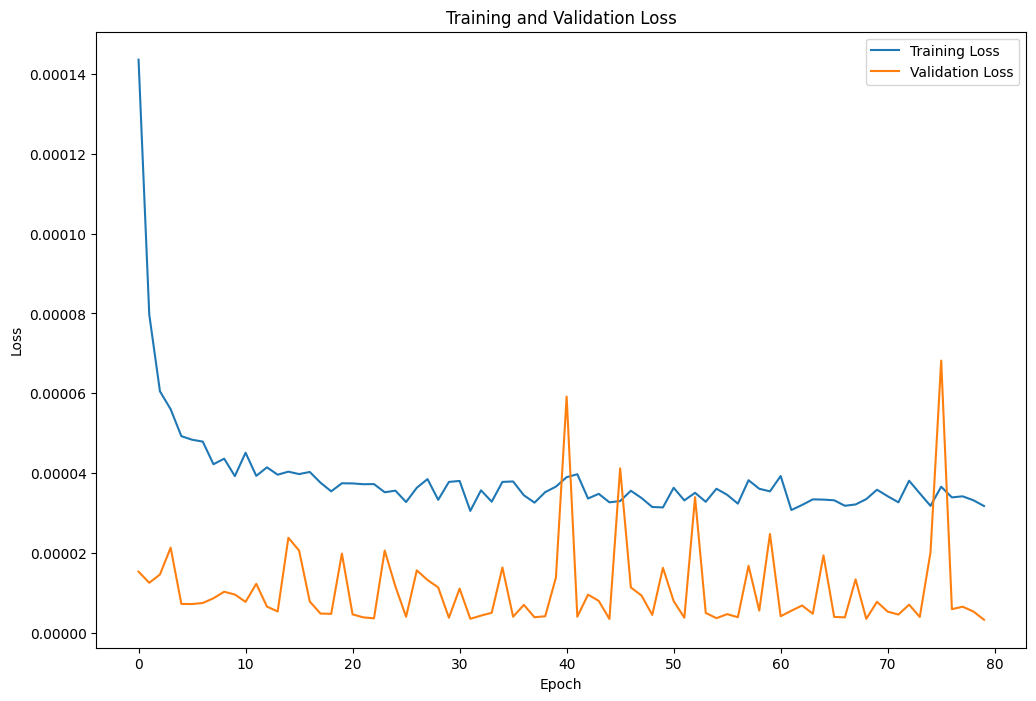

In [14]:
history = pipeline.get_history()

# plot the training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Text(0.5, 1.0, 'LSTM Prediction')

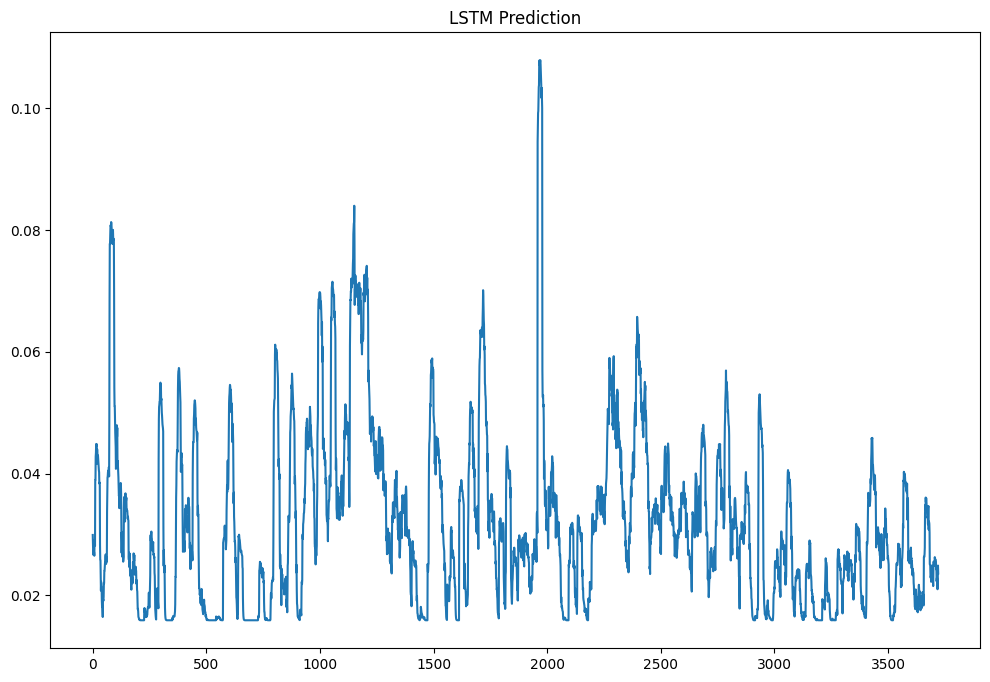

In [18]:
# plot y_pred

y_pred = pipeline.predict(data)
plt.figure(figsize=(12, 8))
plt.plot( y_pred, label="LSTM Prediction")
plt.title("LSTM Prediction")

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
(3722, 1)


ValueError: x and y must have same first dimension, but have shapes (3747,) and (3722, 1)

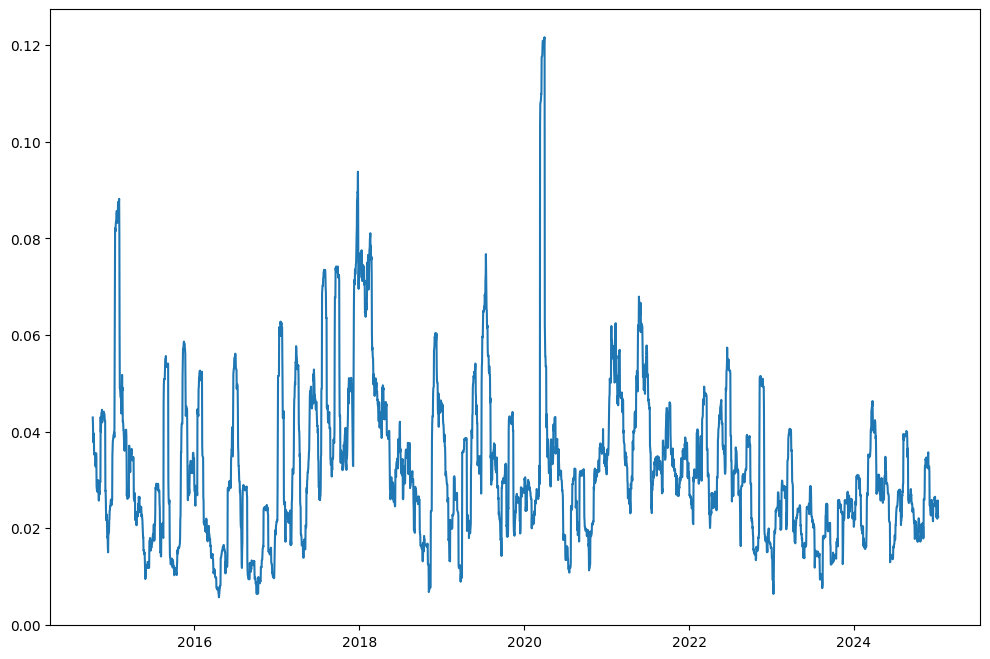

In [15]:
y_pred= pipeline.predict(data)
print(y_pred.shape)

# plot the predicted volatility
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(features["Date"], features["Volatility"], label="Realized Volatility")
ax.plot(features["Date"], y_pred, label="LSTM Prediction")
ax.set_title("LSTM Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
ax.legend()

### Modèle GRU

In [32]:
from crypto_volatility_lab.modeling import GRUPipeline

data = features[["Volatility"]].values
pipeline = GRUPipeline(forecast_horizon=5, epochs=80, batch_size=32, validation_split=0.1)

model = pipeline.fit(data, features["Volatility"].values.astype(np.float64))

Epoch 1/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.7590e-04 - val_loss: 2.0924e-05
Epoch 2/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2286e-04 - val_loss: 2.9811e-05
Epoch 3/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.3163e-05 - val_loss: 1.3788e-05
Epoch 4/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.9319e-05 - val_loss: 1.5313e-05
Epoch 5/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.3339e-05 - val_loss: 4.0652e-05
Epoch 6/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.3027e-05 - val_loss: 1.2043e-05
Epoch 7/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.9143e-05 - val_loss: 1.1849e-05
Epoch 8/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.4841e-05 - val_loss: 1.0752e-05
Epoch 9/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.3637e-05 - val_loss: 1.3345e-05
Epoch 10/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0209e-05 - val_loss: 1.7422e-05
Epoch 11/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/

In [33]:
pipeline.evaluate_metrics(data, features["Volatility"].values.astype(np.float64))

Mean Squared Error (MSE): 0.0001
Mean Absolute Error (MAE): 0.0052
Mean Absolute Percentage Error (MAPE): 16.5216%


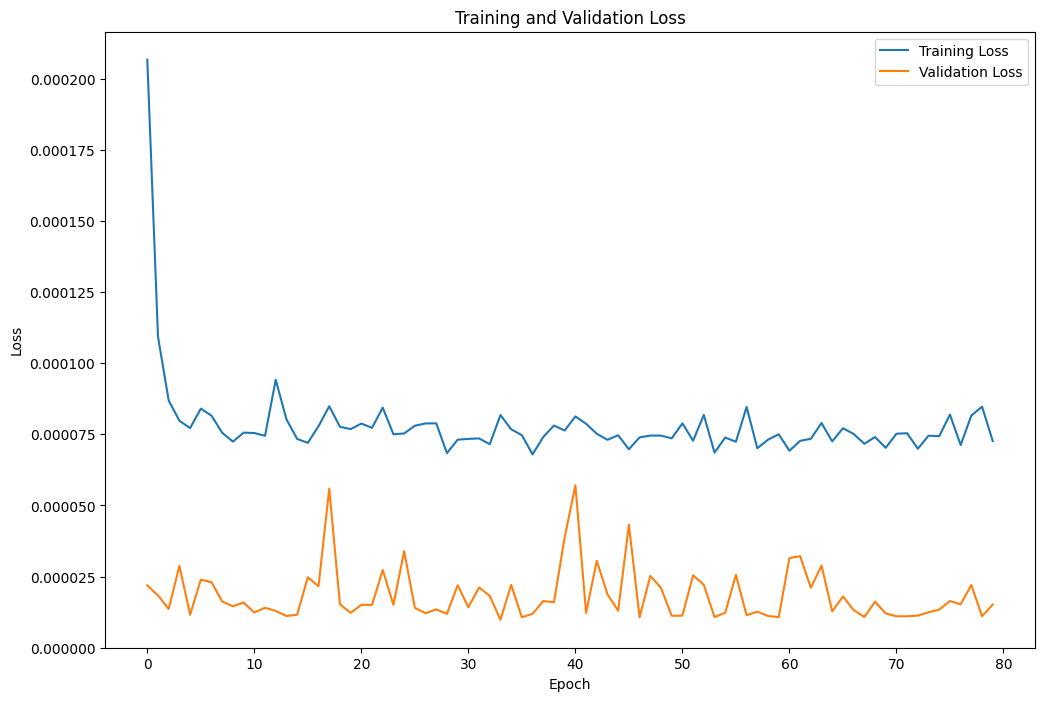

In [27]:
history = pipeline.get_history()

# plot the training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Modèle GRU-LSTM

In [22]:
from crypto_volatility_lab.modeling import LSTMGRUPipeline

data = features[["Volatility", "GARCH Volatility", "Volatility (Weekly)", "Volatility (Monthly)"]].values
pipeline = LSTMGRUPipeline(forecast_horizon=5, epochs=80, batch_size=32, validation_split=0.1)

model = pipeline.fit(data, features["Volatility"].values.astype(np.float64))

Epoch 1/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.4056e-04 - val_loss: 2.6484e-05
Epoch 2/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3187e-04 - val_loss: 1.8295e-05
Epoch 3/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0839e-04 - val_loss: 2.4270e-05
Epoch 4/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0010e-04 - val_loss: 1.2418e-05
Epoch 5/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.9088e-05 - val_loss: 1.8351e-05
Epoch 6/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6653e-05 - val_loss: 2.0774e-05
Epoch 7/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9382e-05 - val_loss: 2.0850e-05
Epoch 8/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4449e-05 - val_loss: 1.3242e-05
Epoch 9/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.8870e-05 - val_loss: 1.6466e-05
Epoch 10/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.3668e-05 - val_loss: 1.5200e-05
Epoch 11/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step -

In [23]:
pipeline.evaluate_metrics(data, features["Volatility"].values.astype(np.float64))

Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0046
Mean Absolute Percentage Error (MAPE): 21.9744%


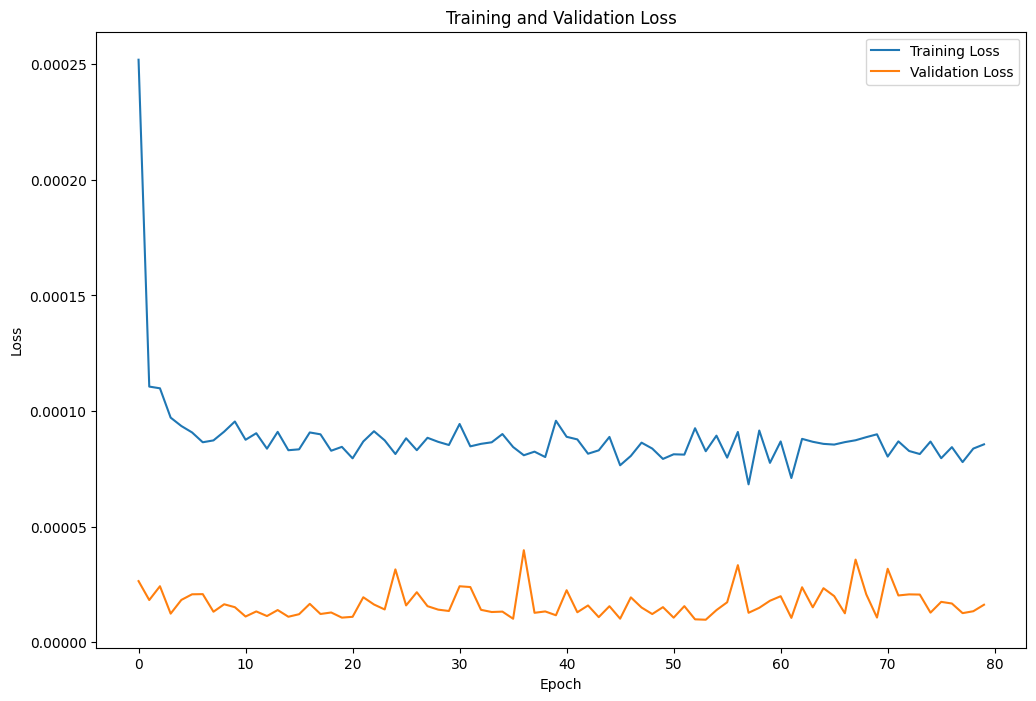

In [24]:
history = pipeline.get_history()

# plot the training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### add test evaluation